**Curso**: Deep Learning

[<img align="right" width="400" height="100" src="https://assets.website-files.com/5f909dbbf6ef7c3b428e2522/60f4592942eda3c0ffb35bfd_Logo_QLAB.svg">](https://qlab.pucp.edu.pe/)


[Pedro Achanccaray](mailto:p.diaz@tu-braunschweig.de), y [Smith Arauco](mailto:saraucoc@uni.pe).


[Pontificia Universidad Católica del Perú](https://www.pucp.edu.pe/)  
[Laboratorio de Inteligencia Artificial y Métodos Computacionales en Ciencias Sociales](https://qlab.pucp.edu.pe/formacion-continua)

# Lab 5: RNN
En esta sesión vamos a ver los siguientes temas:

- Predicción de los pasajeros de las aerolíneas internacionales (LSTM).
- LSTM para Regresión Usando el Método de la Ventana

## Montar Google Drive a Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importando packages necesarios

In [2]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

# semilla aleatoria para rerpoducibilidad
numpy.random.seed(7)

## Conjunto de datos



```
# Tiene formato de código
```

- Vamos a trabajar con el conjunto de datos disponible de forma gratuita en la página web de DataMarket.

- Los datos van de enero de 1949 a diciembre de 1960 o 12 años, con 144 observaciones.

<center>
<img width=500 src="https://unipython.com/wp-content/uploads/2018/09/Figure_1.png" img>
</center>

La primera columna que contiene el recuento de pasajeros de este mes (t) y la segunda columna que contiene el recuento de pasajeros del mes siguiente (t+1), que debe predecirse.


### Cargando los datos

Para cargar el conjunto de datos usaremos a biblioteca Pandas. Para luego onvertir los valores enteros en valores de coma flotante que son más adecuados para modelar con una red neuronal.



In [3]:
# cargamos el conjunto de datos
dataframe = read_csv('/content/drive/MyDrive/Colab Notebooks/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

Las Redes recurrentes son sensibles a la escala de los datos de entrada, especialmente cuando se utilizan las funciones de activación sigmoide (por defecto) o tanh. Puede ser una buena práctica reescalar los datos al rango de 0 a 1, también llamado normalización

In [4]:
# normalizacion de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### Entrenamiento y Pruebas

In [5]:
#dividimos datos en entreno y datos para el test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Creamos un función para crear un nuevo conjunto de datos tal y como se ha descrito anteriormente. La función toma dos argumentos, el conjunto de datos que es un array NumPy que queremos convertir en un conjunto de datos y el look_back, que es el número de pasos de tiempo previos que se deben utilizar como variables de entrada para predecir el siguiente período de tiempo.

<center>
<img width=1000 src="https://i.ibb.co/XCbJfMV/Windows.png" img>
</center>



In [6]:
# convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

In [7]:
# remodelamos X=t y Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX.shape

(92, 3)

La red recorrentes espera que los datos de entrada (X) se proporcionen con una estructura de matriz específica en forma de: [muestras, pasos de tiempo, características]. Nuestros datos preparados están en la forma: [muestras, características] y estamos enmarcando el problema como un paso de tiempo para cada muestra.

In [8]:
# cambiar la forma de la entrada para que sea[muestras, pasos de tiempo, características]
#trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# cambiar la forma de la entrada para que sea[muestras, pasos de tiempo, características]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
testX = numpy.reshape(testX, (testX.shape[0],testX.shape[1],1))
trainX.shape

(92, 3, 1)

## Modelo LSTM para Regresión


Código basado en [PREDICCIÓN CON SERIES TEMPORALES CON LSTM, REDES NEURONALES RECURRENTES](https://unipython.com/prediccion-con-series-temporales-con-lstm-redes-neuronales-recurrentes/)


La red recorrente basiada en LSTM tiene una capa visible con 1 entrada, una capa oculta con 4 bloques LSTM o neuronas y una capa de salida que hace una sola predicción de valor.



Construyendo nuestra red recurente

In [9]:
# creacion de la red LSTM
model = Sequential()
#model.add(LSTM(4, input_shape=(1, look_back)))
model.add(LSTM(8, input_shape=(look_back,1),return_sequences=True))
model.add(LSTM(4, input_shape=(look_back,1)))
model.add(Dense(1))

# look_back - Moficar
# LSTMs - mumero de neuronas, Cuantas Lstms, y que valores tendria sus neuronios
# Modificar la Funcion de activacion, leaning rate, optimizador (opcional)

### Visualizacion de la red LSTM

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 8)              320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533 (2.08 KB)
Trainable params: 533 (2.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


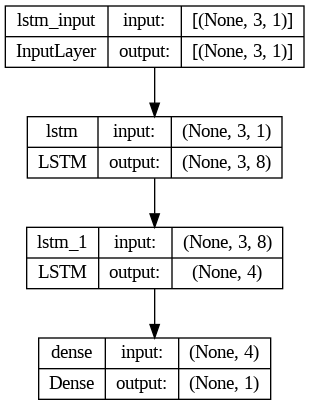

In [11]:
plot_model(model, to_file="model_lstm.png", show_shapes=True)

### Configuración de Entrenamiento

In [12]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
trainX.shape

(92, 3, 1)

## Training

In [14]:
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

## Evaluando el Modelo

In [15]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 5ms/step


In [16]:
# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

## Visualizando las predicciones

In [17]:
# calculamos el error rms
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Resultado del test: %.2f RMSE' % (testScore))

Resultado del entrenamiento: 25.85 RMSE
Resultado del test: 74.89 RMSE


In [18]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


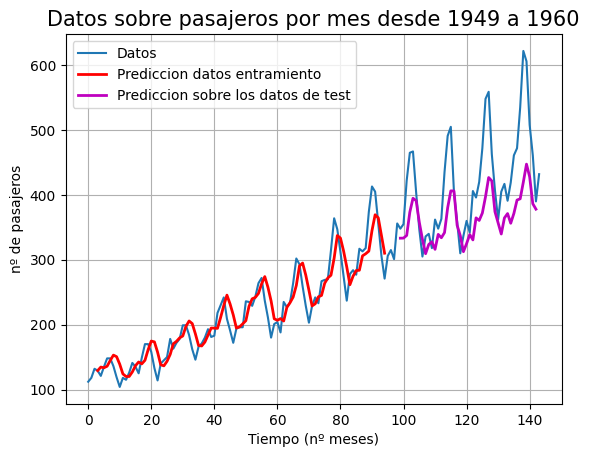

In [19]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()